In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm  # 匯入tqdm來顯示進度條

# Dense Layer

In [11]:
# 定義Dense Layer
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        # 定義批次標準化層
        self.bn = nn.BatchNorm2d(in_channels)
        # 定義ReLU激活函數
        self.relu = nn.ReLU(inplace=True)
        # 定義1x1卷積層
        self.conv1x1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        # 定義3x3卷積層
        self.conv3x3 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        # 前向傳播過程：先批次標準化，然後激活，接著經過1x1卷積，再經過3x3卷積
        out = self.conv1x1(self.relu(self.bn(x)))
        out = self.conv3x3(self.relu(out))
        # 輸入和輸出做連接
        out = torch.cat([x, out], 1)
        return out

# Dense Block

In [12]:
# 定義Dense Block
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        # 堆疊多個Dense Layer
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        # 使用Sequential將層串接起來
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Transition Layer

In [13]:
# 定義過渡層 (Transition Layer)
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        # 定義批次標準化層
        self.bn = nn.BatchNorm2d(in_channels)
        # 定義ReLU激活函數
        self.relu = nn.ReLU(inplace=True)
        # 定義1x1卷積層
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        # 定義平均池化層 (AvgPool)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        # 前向傳播過程：批次標準化、激活、1x1卷積、池化
        out = self.conv1x1(self.relu(self.bn(x)))
        out = self.pool(out)
        return out

# DENSENET 169 Architecture

**DENSENET architecture**

<img src='./images/DENSENET1.png' width="1200" align="left">
<img src='./images/DENSENET2.png' width="600" align="left">

In [14]:
# 定義DenseNet架構
class DenseNet169(nn.Module):
    def __init__(self, growth_rate=32, num_classes=10):
        super(DenseNet169, self).__init__()
        # 初始卷積層
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # 批次標準化層
        self.bn1 = nn.BatchNorm2d(64)
        # 最大池化層
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 定義Dense Block 1
        self.block1 = DenseBlock(num_layers=6, in_channels=64, growth_rate=growth_rate)
        self.trans1 = TransitionLayer(in_channels=64 + 6 * growth_rate, out_channels=128)

        # 定義Dense Block 2
        self.block2 = DenseBlock(num_layers=12, in_channels=128, growth_rate=growth_rate)
        self.trans2 = TransitionLayer(in_channels=128 + 12 * growth_rate, out_channels=256)

        # 定義Dense Block 3
        self.block3 = DenseBlock(num_layers=32, in_channels=256, growth_rate=growth_rate)
        self.trans3 = TransitionLayer(in_channels=256 + 32 * growth_rate, out_channels=512)

        # 定義Dense Block 4
        self.block4 = DenseBlock(num_layers=32, in_channels=512, growth_rate=growth_rate)

        # 批次標準化層
        self.bn2 = nn.BatchNorm2d(512 + 32 * growth_rate)
        # 全局平均池化層
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 最終的全連接層
        self.fc = nn.Linear(512 + 32 * growth_rate, num_classes)

    def forward(self, x):
        # 前向傳播：經過初始卷積層
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.pool1(out)

        # 經過第一個Dense Block和過渡層
        out = self.block1(out)
        out = self.trans1(out)

        # 經過第二個Dense Block和過渡層
        out = self.block2(out)
        out = self.trans2(out)

        # 經過第三個Dense Block和過渡層
        out = self.block3(out)
        out = self.trans3(out)

        # 經過第四個Dense Block
        out = self.block4(out)

        # 最後批次標準化、全局平均池化
        out = self.bn2(out)
        out = F.relu(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        # 經過全連接層輸出結果
        out = self.fc(out)
        return out

In [15]:
# Create a DenseNet model
model = DenseNet169()

# Print the architecture of the model
print(model)

DenseNet169(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): DenseBlock(
    (net): Sequential(
      (0): DenseLayer(
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv1x1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv3x3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): DenseLayer(
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv1x1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv3x3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

# Train DenseNet , Data set -> (CIFAR-10)

In [8]:
# 準備CIFAR-10資料集和訓練流程
def train_densenet():
    # 定義資料增強和標準化的變換
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # 下載並加載CIFAR-10訓練和測試數據
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=8)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

    # 使用CUDA加速
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 初始化DenseNet169模型
    model = DenseNet169().to(device)

    # 定義損失函數和優化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

    # 訓練模型
    epochs = 50 # 訓練20個epoch
    epoch_losses = []  # 記錄每個 epoch 的平均損失

    # 訓練模型
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        batch_count = 0

        # 使用 tqdm 創建進度條
        train_loader_tqdm = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for i, (inputs, labels) in enumerate(train_loader_tqdm):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # 清除前一次的梯度
            outputs = model(inputs)  # 前向傳播
            loss = criterion(outputs, labels)  # 計算損失
            loss.backward()  # 反向傳播
            optimizer.step()  # 更新參數

            running_loss += loss.item()
            batch_count += 1
            # 更新進度條描述
            train_loader_tqdm.set_postfix(loss=f"{running_loss / (i + 1):.4f}")
            '''
            if i % 100 == 99:  # 每100個batch顯示一次
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.4f}')
                running_loss = 0.0
            '''
        # 計算每個 epoch 的平均損失並存入列表
        epoch_loss = running_loss / batch_count
        epoch_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1} 平均損失: {epoch_loss:.4f}')

    print('訓練完成')

    # 測試模型
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'測試準確率: {100 * correct / total:.2f}%')
    
    # 假設 model 是你的模型，將其參數儲存為 'model.pth'
    torch.save(model.state_dict(), 'DenseNet169_model.pth')
    # 儲存完整模型
    torch.save(model, 'complete_model.pth')

    import json

    # 將損失數據保存為JSON文件
    with open('DenseNet169_epoch_losses.json', 'w') as f:
        json.dump(epoch_losses, f)

    return epoch_losses

# 解釋:
1. **Dense Layer 和 Dense Block** : 每個 Dense Layer 包含兩個卷積層，`1x1` 和 `3x3`，前向傳播中會將輸入與輸出拼接。`Dense Block` 則由多個 `Dense Layer` 組成。
2. **Transition Layer**: 用來壓縮通道數，並進行下採樣。
3. **DenseNet169 架構**: 根據 DenseNet 的設計，在不同的位置堆疊 `Dense Block` 和 `Transition Layer`，最終通過全局平均池化後，進行分類。
4. **CIFAR-10 測試**: 使用 `CIFAR-10` 資料集進行模型訓練和測試。

In [1]:
import matplotlib.pyplot as plt  # 匯入matplotlib來進行繪圖

In [6]:
# 訓練完成後繪製圖表
def plot_losses(epoch_losses):
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

In [11]:
# 執行訓練
epoch_losses = train_densenet()

Files already downloaded and verified
Files already downloaded and verified


Epoch 1/50: 100%|████████████████████████████████████████████████████| 196/196 [01:34<00:00,  2.08batch/s, loss=1.7850]


Epoch 1 平均損失: 1.7850


Epoch 2/50: 100%|████████████████████████████████████████████████████| 196/196 [01:32<00:00,  2.12batch/s, loss=1.4526]


Epoch 2 平均損失: 1.4526


Epoch 3/50: 100%|████████████████████████████████████████████████████| 196/196 [01:30<00:00,  2.17batch/s, loss=1.3119]


Epoch 3 平均損失: 1.3119


Epoch 4/50: 100%|████████████████████████████████████████████████████| 196/196 [01:32<00:00,  2.13batch/s, loss=1.2031]


Epoch 4 平均損失: 1.2031


Epoch 5/50: 100%|████████████████████████████████████████████████████| 196/196 [01:31<00:00,  2.13batch/s, loss=1.1217]


Epoch 5 平均損失: 1.1217


Epoch 6/50: 100%|████████████████████████████████████████████████████| 196/196 [01:31<00:00,  2.14batch/s, loss=1.0650]


Epoch 6 平均損失: 1.0650


Epoch 7/50: 100%|████████████████████████████████████████████████████| 196/196 [01:32<00:00,  2.12batch/s, loss=1.0187]


Epoch 7 平均損失: 1.0187


Epoch 8/50: 100%|████████████████████████████████████████████████████| 196/196 [01:32<00:00,  2.12batch/s, loss=0.9712]


Epoch 8 平均損失: 0.9712


Epoch 9/50: 100%|████████████████████████████████████████████████████| 196/196 [01:32<00:00,  2.11batch/s, loss=0.9298]


Epoch 9 平均損失: 0.9298


Epoch 10/50: 100%|███████████████████████████████████████████████████| 196/196 [01:32<00:00,  2.12batch/s, loss=0.8939]


Epoch 10 平均損失: 0.8939


Epoch 11/50: 100%|███████████████████████████████████████████████████| 196/196 [01:32<00:00,  2.13batch/s, loss=0.8606]


Epoch 11 平均損失: 0.8606


Epoch 12/50: 100%|███████████████████████████████████████████████████| 196/196 [01:28<00:00,  2.21batch/s, loss=0.8341]


Epoch 12 平均損失: 0.8341


Epoch 13/50: 100%|███████████████████████████████████████████████████| 196/196 [01:38<00:00,  1.99batch/s, loss=0.8070]


Epoch 13 平均損失: 0.8070


Epoch 14/50: 100%|███████████████████████████████████████████████████| 196/196 [01:33<00:00,  2.11batch/s, loss=0.7859]


Epoch 14 平均損失: 0.7859


Epoch 15/50: 100%|███████████████████████████████████████████████████| 196/196 [01:35<00:00,  2.05batch/s, loss=0.7634]


Epoch 15 平均損失: 0.7634


Epoch 16/50: 100%|███████████████████████████████████████████████████| 196/196 [01:47<00:00,  1.82batch/s, loss=0.7425]


Epoch 16 平均損失: 0.7425


Epoch 17/50: 100%|███████████████████████████████████████████████████| 196/196 [01:42<00:00,  1.92batch/s, loss=0.7208]


Epoch 17 平均損失: 0.7208


Epoch 18/50: 100%|███████████████████████████████████████████████████| 196/196 [01:44<00:00,  1.88batch/s, loss=0.6990]


Epoch 18 平均損失: 0.6990


Epoch 19/50: 100%|███████████████████████████████████████████████████| 196/196 [01:44<00:00,  1.88batch/s, loss=0.6890]


Epoch 19 平均損失: 0.6890


Epoch 20/50: 100%|███████████████████████████████████████████████████| 196/196 [01:41<00:00,  1.92batch/s, loss=0.6704]


Epoch 20 平均損失: 0.6704


Epoch 21/50: 100%|███████████████████████████████████████████████████| 196/196 [01:33<00:00,  2.10batch/s, loss=0.6520]


Epoch 21 平均損失: 0.6520


Epoch 22/50: 100%|███████████████████████████████████████████████████| 196/196 [01:41<00:00,  1.94batch/s, loss=0.6344]


Epoch 22 平均損失: 0.6344


Epoch 23/50: 100%|███████████████████████████████████████████████████| 196/196 [01:45<00:00,  1.85batch/s, loss=0.6193]


Epoch 23 平均損失: 0.6193


Epoch 24/50: 100%|███████████████████████████████████████████████████| 196/196 [01:42<00:00,  1.91batch/s, loss=0.6126]


Epoch 24 平均損失: 0.6126


Epoch 25/50: 100%|███████████████████████████████████████████████████| 196/196 [01:38<00:00,  1.98batch/s, loss=0.5911]


Epoch 25 平均損失: 0.5911


Epoch 26/50: 100%|███████████████████████████████████████████████████| 196/196 [01:35<00:00,  2.05batch/s, loss=0.5798]


Epoch 26 平均損失: 0.5798


Epoch 27/50: 100%|███████████████████████████████████████████████████| 196/196 [01:43<00:00,  1.89batch/s, loss=0.5650]


Epoch 27 平均損失: 0.5650


Epoch 28/50: 100%|███████████████████████████████████████████████████| 196/196 [01:42<00:00,  1.92batch/s, loss=0.5574]


Epoch 28 平均損失: 0.5574


Epoch 29/50: 100%|███████████████████████████████████████████████████| 196/196 [01:44<00:00,  1.88batch/s, loss=0.5465]


Epoch 29 平均損失: 0.5465


Epoch 30/50: 100%|███████████████████████████████████████████████████| 196/196 [01:38<00:00,  1.99batch/s, loss=0.5341]


Epoch 30 平均損失: 0.5341


Epoch 31/50: 100%|███████████████████████████████████████████████████| 196/196 [01:45<00:00,  1.86batch/s, loss=0.5238]


Epoch 31 平均損失: 0.5238


Epoch 32/50: 100%|███████████████████████████████████████████████████| 196/196 [01:49<00:00,  1.79batch/s, loss=0.5103]


Epoch 32 平均損失: 0.5103


Epoch 33/50: 100%|███████████████████████████████████████████████████| 196/196 [01:48<00:00,  1.80batch/s, loss=0.4910]


Epoch 33 平均損失: 0.4910


Epoch 34/50: 100%|███████████████████████████████████████████████████| 196/196 [01:45<00:00,  1.85batch/s, loss=0.4824]


Epoch 34 平均損失: 0.4824


Epoch 35/50: 100%|███████████████████████████████████████████████████| 196/196 [01:46<00:00,  1.85batch/s, loss=0.4783]


Epoch 35 平均損失: 0.4783


Epoch 36/50: 100%|███████████████████████████████████████████████████| 196/196 [01:44<00:00,  1.88batch/s, loss=0.4722]


Epoch 36 平均損失: 0.4722


Epoch 37/50: 100%|███████████████████████████████████████████████████| 196/196 [01:44<00:00,  1.87batch/s, loss=0.4570]


Epoch 37 平均損失: 0.4570


Epoch 38/50: 100%|███████████████████████████████████████████████████| 196/196 [01:44<00:00,  1.87batch/s, loss=0.4478]


Epoch 38 平均損失: 0.4478


Epoch 39/50: 100%|███████████████████████████████████████████████████| 196/196 [01:42<00:00,  1.91batch/s, loss=0.4422]


Epoch 39 平均損失: 0.4422


Epoch 40/50: 100%|███████████████████████████████████████████████████| 196/196 [01:47<00:00,  1.83batch/s, loss=0.4285]


Epoch 40 平均損失: 0.4285


Epoch 41/50: 100%|███████████████████████████████████████████████████| 196/196 [01:48<00:00,  1.81batch/s, loss=0.4160]


Epoch 41 平均損失: 0.4160


Epoch 42/50: 100%|███████████████████████████████████████████████████| 196/196 [01:45<00:00,  1.86batch/s, loss=0.4108]


Epoch 42 平均損失: 0.4108


Epoch 43/50: 100%|███████████████████████████████████████████████████| 196/196 [01:45<00:00,  1.86batch/s, loss=0.4027]


Epoch 43 平均損失: 0.4027


Epoch 44/50: 100%|███████████████████████████████████████████████████| 196/196 [01:44<00:00,  1.88batch/s, loss=0.4004]


Epoch 44 平均損失: 0.4004


Epoch 45/50: 100%|███████████████████████████████████████████████████| 196/196 [01:41<00:00,  1.93batch/s, loss=0.3846]


Epoch 45 平均損失: 0.3846


Epoch 46/50: 100%|███████████████████████████████████████████████████| 196/196 [01:35<00:00,  2.05batch/s, loss=0.3803]


Epoch 46 平均損失: 0.3803


Epoch 47/50: 100%|███████████████████████████████████████████████████| 196/196 [01:37<00:00,  2.01batch/s, loss=0.3669]


Epoch 47 平均損失: 0.3669


Epoch 48/50: 100%|███████████████████████████████████████████████████| 196/196 [01:48<00:00,  1.81batch/s, loss=0.3596]


Epoch 48 平均損失: 0.3596


Epoch 49/50: 100%|███████████████████████████████████████████████████| 196/196 [01:48<00:00,  1.81batch/s, loss=0.3558]


Epoch 49 平均損失: 0.3558


Epoch 50/50: 100%|███████████████████████████████████████████████████| 196/196 [01:51<00:00,  1.76batch/s, loss=0.3454]


Epoch 50 平均損失: 0.3454
訓練完成
測試準確率: 76.38%


[1.7849767858884773, 1.45260559843511, 1.3119392449758491, 1.203050128051213, 1.1217103649158866, 1.0650231850390532, 1.0186996669793615, 0.9711733457385278, 0.9298428214934408, 0.8939153658492225, 0.8606279319038197, 0.8340713892664228, 0.8069642614953372, 0.7858637978835982, 0.7634168893707042, 0.7424769666121931, 0.7207993454470927, 0.6990188059149957, 0.6890395070825305, 0.6703559187602024, 0.6520012893847057, 0.6344146092935484, 0.6193319379675145, 0.6126447805032438, 0.5910723948357056, 0.5798383113376948, 0.5650391455511657, 0.5574041015031387, 0.5465100263150371, 0.5340999206718133, 0.5237519294023514, 0.5103151524553493, 0.4910486057704809, 0.48238906918131574, 0.478318172602021, 0.47224849690588155, 0.45695678540030304, 0.4478244966998392, 0.44222392597976995, 0.4284751553620611, 0.41596283702826015, 0.41084417791999117, 0.40272803330908014, 0.4003695722441284, 0.3845743465484405, 0.3802579689999016, 0.3669031057886931, 0.3596263371255933, 0.3558104359829912, 0.34535989286948

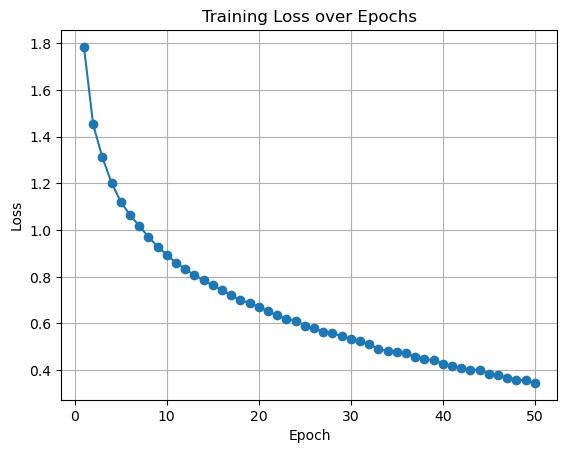

In [7]:
import json
# 訓練完成後畫損失圖
with open('DenseNet169_epoch_losses.json', 'r') as f:
    epoch_losses = json.load(f)

print(epoch_losses)  # 輸出損失數據
plot_losses(epoch_losses)

# 加載模型去predicted

C:\Users\eddyw\AppData\Local\Temp\ipykernel_34660\3300039323.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('DenseNet169_model.pth'))


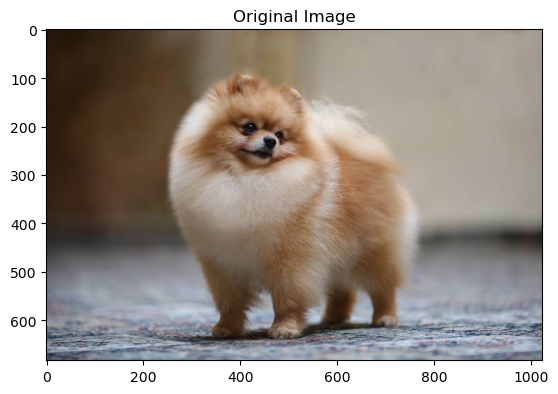

預測的類別是: dog


In [18]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# 定義模型結構（確保和訓練時一致）
model = DenseNet169()

# 加載已保存的模型參數
model.load_state_dict(torch.load('DenseNet169_model.pth'))

# 使用GPU（如果有的話）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 設置為推論模式
model.eval()

'''
# 加載完整模型
model = torch.load('complete_model.pth')
model.to(device)

# 設置為推論模式
model.eval()
'''

# 圖像預處理
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # CIFAR-10 圖像大小
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加載並預處理圖像
img = Image.open('dog.jpeg')  # 替換為你要識別的圖像路徑
# 顯示原始圖像
plt.imshow(img)
plt.title('Original Image')
plt.show()

img = transform(img)
img = img.unsqueeze(0)  # 增加 batch 維度 (1, C, H, W)
img = img.to(device)

# 禁用梯度計算，進行推論
with torch.no_grad():
    outputs = model(img)

# 找出預測的類別
_, predicted = torch.max(outputs, 1)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predicted_class = classes[predicted.item()]

print(f'預測的類別是: {predicted_class}')
